# Import required libraries 

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Plot visualization function

In [2]:
def display_image_row(image_list, titles_list, figsize=(10,10)):
    n_images = len(image_list)

    plt.figure(figsize=figsize)
    for i, img in enumerate(image_list):
        plt.subplot(1,n_images,i + 1)
        if len(img.shape) == 3:
            plt.imshow(img)
        else:
            plt.imshow(img, cmap="gray")
        plt.title(titles_list[i])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Load images and visualize channels

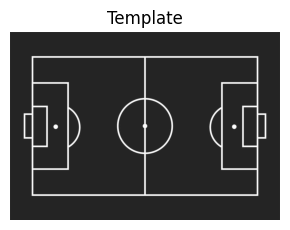

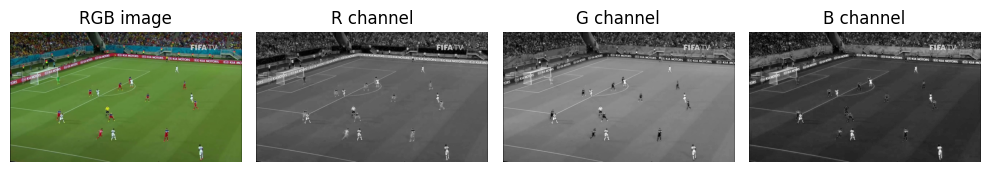

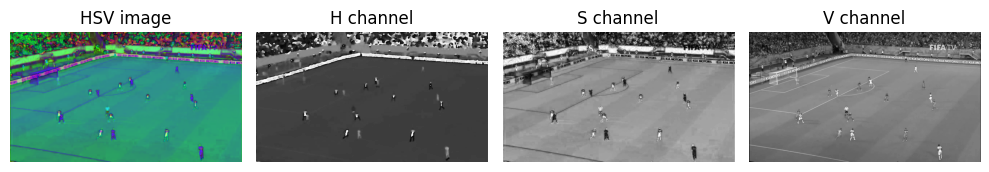

In [96]:
IMAGE_PATH = "../../Datasets/object detection images/test_1.jpg"
TEMPLATE_PATH = "../../Datasets/soccer field layout/soccer_field_layout_2.jpg"

# Load field template in grayscale
gray_template = cv2.imread(TEMPLATE_PATH, cv2.IMREAD_GRAYSCALE)
display_image_row([gray_template], ["Template"], figsize=(3,3))

# Load test image and apply color space conversion
image_bgr = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

r, g, b = cv2.split(image_rgb)
h, s, v = cv2.split(image_hsv)

image_rgb_list = [image_rgb, r, g, b]
titles_rgb_list = ["RGB image", "R channel", "G channel", "B channel"]

image_hsv_list = [image_hsv, h, s, v]
titles_hsv_list = ["HSV image", "H channel", "S channel", "V channel"]

display_image_row(image_rgb_list, titles_rgb_list, figsize=(10,10))
display_image_row(image_hsv_list, titles_hsv_list, figsize=(10,10))

# Image segmentation by color

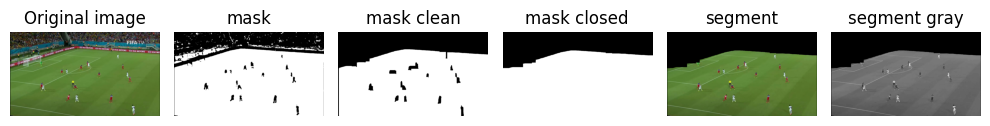

In [97]:
# Define range of green color in HSV
# Note: These values can be adjusted depending on the shade of green you're interested in
lower_green = np.array([35, 50, 50])
upper_green = np.array([85, 255, 255])

# Threshold the HSV image to get only green colors
mask = cv2.inRange(image_hsv, lower_green, upper_green)

# Apply closing to fill holes in the mask (dilation followed by erosion)
kernel = np.ones((10, 10), np.uint8)

# Apply opening to remove noise from the mask (erosion followed by dilation)
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=5)
mask_closed = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel, iterations=10)

# Bitwise-AND mask and original image (optional)
green_segment = cv2.bitwise_and(image_rgb, image_rgb, mask=mask_closed)
gray_image = cv2.cvtColor(green_segment, cv2.COLOR_RGB2GRAY)

display_image_row([image_rgb, mask, mask_clean, mask_closed, green_segment, gray_image], 
                  ["Original image", "mask", "mask clean","mask closed", "segment", "segment gray"])

# Feature matching and homography computation

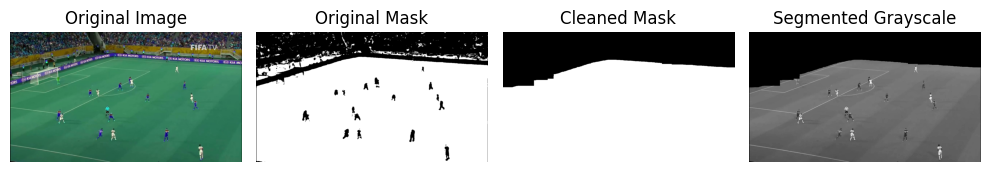

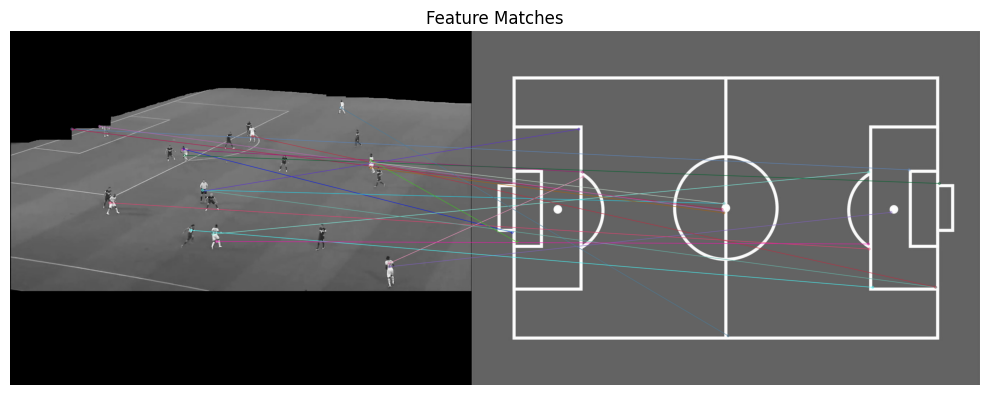

In [98]:
def visualize_steps(image, mask, mask_clean, gray_image, matches, keypoints1, keypoints2, gray_template):
    """Visualize intermediate steps using the provided display function."""
    # Prepare images for display (convert BGR images to RGB for correct color representation)
    original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    template_rgb = cv2.cvtColor(gray_template, cv2.COLOR_BGR2RGB)
    
    # Draw first 20 matches.
    match_img = cv2.drawMatches(gray_image, keypoints1, gray_template, keypoints2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Display images
    display_image_row([original_rgb, mask, mask_clean, gray_image], ["Original Image", "Original Mask", "Cleaned Mask", "Segmented Grayscale"])
    display_image_row([match_img], ["Feature Matches"])

def feature_matching_and_homography(gray_image, gray_template):
    """Perform feature extraction, matching, and compute homography matrix."""
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(gray_image, None)
    keypoints2, descriptors2 = orb.detectAndCompute(gray_template, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x:x.distance)
    
    # Extract matched points
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    # Compute homography
    H, masked = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)
    return H, matches, keypoints1, keypoints2

# Feature matching and homography
H, matches, keypoints1, keypoints2 = feature_matching_and_homography(gray_image, gray_template)
visualize_steps(image_rgb, mask, mask_closed, gray_image, matches, keypoints1, keypoints2, gray_template)

# Apply and visualize homography

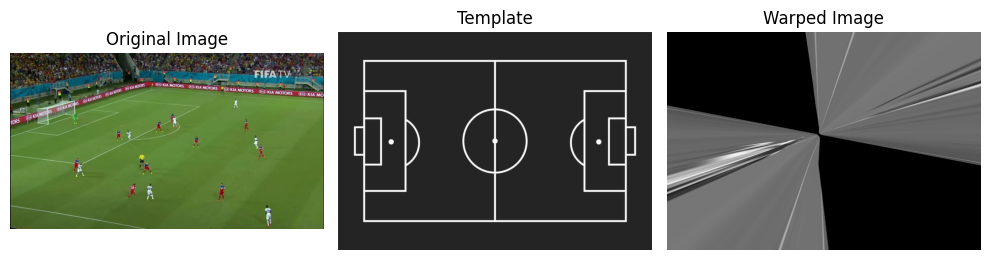

In [99]:
def warp_image_with_homography(gray_image, H, template_size):
    """Apply the computed homography matrix to warp the image."""
    warped_image = cv2.warpPerspective(gray_image, H, (template_size[1], template_size[0]))
    return warped_image

def visualize_final_homography(original_image, template, warped_image):
    """Visualize the original image, template, and warped image."""
    display_image_row([original_image, template, warped_image], ['Original Image', 'Template', 'Warped Image'])

# Example Homography Application and Visualization
template_size = gray_template.shape
warped_image = warp_image_with_homography(gray_image, H, template_size)

visualize_final_homography(image_rgb, gray_template, warped_image)

# Conclusions

The use of automatically detected and selected features based on the functions provided by OpenCV, even after segmenting the region of interest, leads to unreliable keypoints selection and wrong results at the moment of computing the homography matrix.

## Next steps:
Review and implement the approach presented in the following reference, making use of a pretrained model to find relevant keypoints to perform accurate homographies.
- https://github.com/DonsetPG/narya